# 대한민국 vs 코스타리카전 축구 A 매치 데이터로 살펴보기

요새 축구가 개꿀잼이다. 우리흥이 아시안게임에서 금메달따서 군대제껴서 좋고, 신임 대표팀 벤투 감독이 와서 첫 경기를 잘해서 좋다.

오랜만에 A매치를 편안하게 즐기면서 봤는데, 생각하면 할수록 뭔가 이전 대표팀 경기와 많은 부분이 달랐던 것 같다. 코스타리카가 엄청난 강팀이라곤 할 수 없지만, 나름 북중미의 강호인데다, 2014년에 있었던 경기에서는 3:1로 우리가 발렸다. 월드컵때와 달리 우리는 점유율을 높게 가져갔고, 많은 공격 기회를 만들었으며, 공격 기회에서의 패스 성공률도 매우 높게 느껴졌다. 특히 이전의 답없던 뻥축구가 아닌 정확히 구석구석을 찌르는 롱패스를 보면서 '아니 갑자기 왤케 패스를 잘하지?' 라는 생각이 절로 들면서 국대 축구를 보는게 맞나..라는 생각도 들었더란다.

그냥 그랬구나 하고 넘겨보기엔 아쉬워서 SBS에서 다시보기를 구매한 후 클립을 보면서 데이터를 만들어봤다. 언젠가는 영상인식으로 축구 데이터를 뽑을 수 있기를..

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "vsCostarica_20180908/"
dataframe = pd.read_csv(os.path.join(data_dir, "attackingThirdRecord.csv"))

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 7 columns):
team               74 non-null object
half               74 non-null object
time               74 non-null object
from               74 non-null object
to                 74 non-null object
passtype(단/중/장)    74 non-null object
isSuccess          74 non-null object
dtypes: object(7)
memory usage: 4.1+ KB


In [4]:
dataframe.head()

,team,half,time,from,to,passtype(단/중/장),isSuccess
0,kor,1st,0:38,김영권,손흥민,장,성공
1,kor,1st,2:27,기성용,손흥민,장,실패
2,kor,1st,5:13,홍철,손흥민,단,성공
3,kor,1st,6:22,김영권,남태희,장,실패
4,kor,1st,6:32,장현수,이용,중,성공


## Dataset Info

데이터 해상도가 높으면 높을수록 더 디테일한 분석을 할 수 있겠지만, 해상도 상승에 따른 노가다의 양은 지수적으로 증가한다. 오늘 퇴근길에 생각한 이 씨잘데기없는 상상을 구현하는데 2시간 이상의 시간을 쓸 계획은 없다. 따라서 `아니 우리 공격 패스 왤케 잘하지?`만 검증해보기 위한 데이터셋을 만들어보기로 했다.

모든 패스를 기록하기에는 너무 양이 많고 분류가 어려우므로, 상대 문전앞 Attacking Third(이하 at)에 진입하는 키 패스를 따기로 했다. at에 진입하는 패스는 모든 적극적 공격의 시발점이 되므로 해석하기에도 쉽고, 양도 적당해서 기록하기에도 좋았다.

Attacking Third는 아래 그림과 같이 전체 경기장을 3등분으로 나눈 부분 중 적진에 해당하는 영역을 의미한다.

<img src="assets/attackingthird.png" alt="Drawing" style="width: 400px;"/>
source: https://www.globallcoach.com/blog/2018/3/23/zone-14-explaining-the-trends-and-buzzwords

이 영역에 볼이 넘어가는 방식을 장거리 / 중거리 / 단거리 / 개인돌파로 나누고 이 횟수를 카운팅해보았다. 코스타리카전에서의 장/중/단 패스와 개인돌파의 예시는 다음과 같다.

### 장거리 패스
![장거리패스](assets/long.gif)


### 중거리 패스
![장거리패스](assets/mid.gif)


### 단거리 패스
![단거리패스](assets/short.gif)


### 개인돌파
![개인돌파](assets/indiv.gif)

각 패스의 메타 정보를 함께 기록해 다음과 같은 데이터프레임을 만들었다.

- team: kor (대한민국) / cos (코스타리카)
- half: 1st (전반) / 2nd (후반)
- time: minute:second (전후반 분할)
- from: 패스를 한 선수 (이름을 모르면 등번호, 아예 모르면 ?표시)
- to: 패스를 받은 선수 (마찬가지)
- passtype(단/중/장)
  - attacking third (이하 at) 밖에서 안으로 이어지는 연결을 pass로 정의함
  - at 밖으로 유의미하게 나갔다가 다시 들어오는 경우 pass로 인정
  - 슛, 코너킥은 No인정
  - 타입 구분
    - 단: 선수간 거리가 가까워보이는 경우 (자의적 판단)
    - 중: 중앙선에서 at로 패스가 이어지거나, `단`보다는 조금 긴 경우
    - 장: 수비라인 후방에서 at로 패스가 바로 이어지는 경우
    - 개인돌파: at밖에서 안으로 선수가 독자적으로 드리블해서 진입하는 경우
- isSuccess:
    - 단/중/장 패스는 패스를 받는 선수가 무사히 퍼스트 터치를 하는 경우 성공으로 판정
    - 개인돌파는 at안으로 진입후, 크로스/슈팅을 한 경우 성공, 차단당하는 경우 실패로 판정
    
단/중 분류에 내 주관적인 판단과 그당시 눈의 피로도가 조금 영향을 미쳤지만, 그건 그냥 넘어가도록 한다.
다시보기 클립을 보면서 위의 데이터셋을 정리하는데는 약 30분 정도가 소요되었다. at를 넘어가는 공격 부분만 보면 되니까 시간은 생각보다 오래걸리지 않았다. 문득 국대 대표팀 분석실에서는 어떤 방식으로 데이터를 확보하는지 궁금해졌다. 아마 영상인식 알고리즘이나 장비같은걸 써서 수비대열 측정이나 경기 템포 등을 정량화하지 않나 싶다. 

여튼 정리한 데이터를 몇가지 측면에서 살펴보자.

## 대한민국이 약 2.5배 더 많은 공격 기회를 가져갔다.
전후반 합쳐 한국은 55회 공격했지만, 코스타리카는 19회에 그쳤다.

In [5]:
dataframe.groupby('team').time.count()

team
cos    19
kor    55
Name: time, dtype: int64

## 전후반 공격 기회는 두 팀 다 비슷했다.
하프타임에 기성용이 빠졌지만, 한국의 공격기회는 전반 30회, 후반 25회로 비슷했다. 기분탓?이었나보다.

In [6]:
dataframe.groupby(['team', 'half']).time.count()

team  half
cos   1st      9
      2nd     10
kor   1st     30
      2nd     25
Name: time, dtype: int64

## 대한민국은 중반에 조금 숨을 돌리는 듯?
at를 넘어간 패스를 시간순으로 찍어보면 전반/후반에 초중반과 중후반에 몰리고 중간은 조금 비어있다. 45분 내내 공격하는 것도 상당히 지칠 것 같다. 코스타리카는 이번에 시차적응이 좀 덜된 듯. 드문드문 공격했다.

In [7]:
def convert_time(a_time_str):
    _min, _sec = a_time_str.split(":")
    _min, _sec = int(_min), int(_sec)
    return _min * 60 + _sec
    
dataframe['ts_in_sec'] = dataframe.time.map(convert_time)

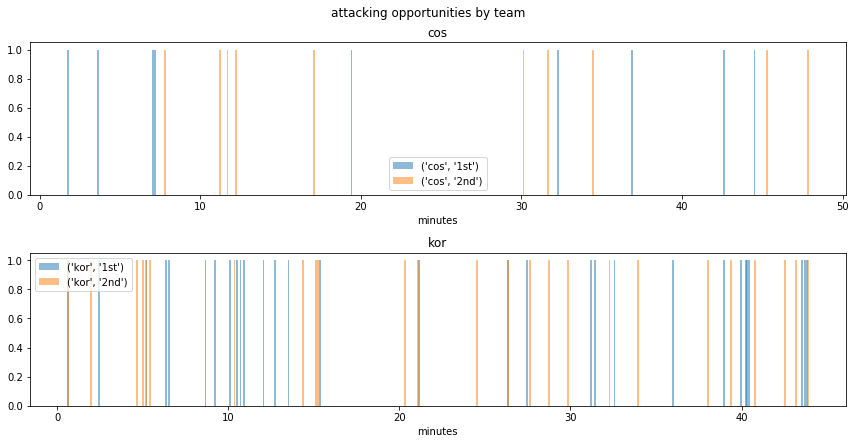

In [8]:
g = dataframe.groupby(['team', 'half'])

fig, ax = plt.subplots(2, figsize=(12, 6))
for ax_idx, (label, data) in enumerate(g):
    nrow = ax_idx // 2
    ax[nrow].bar(data.ts_in_sec / 60, np.ones(len(data.ts_in_sec)), label=label, alpha=0.5, width=0.1)
    ax[nrow].set_title(label[0])
    ax[nrow].legend()
    ax[nrow].set_xlabel("minutes")
    
plt.suptitle("attacking opportunities by team", y=1.02)
fig.tight_layout()
plt.show()

## 코스타리카는 개인돌파가, 대한민국은 중장거리 패스를 많이 썼다.
개인기가 좋은 남미팀이라서 그런지 코스타리카 공격의 26%는 개인돌파였다. 수치상으로는 한국의 개인돌파가 6회로, 코스타리카에 1회 더 많지만, 이보다 더 많은 패스가 중장거리로 이루어졌다. 

재미있는 점은 코스타리카는 장거리 패스가 하나도 없다는 것. 전술의 차이일까?

In [9]:
byTeamPass = dataframe.groupby(['team', 'passtype(단/중/장)'])[['time']].count().rename(columns={'time':'passCnt'})
teamPass = dataframe.groupby('team')[['time']].count().rename(columns={'time':'totalPassCnt'})
merged = byTeamPass.join(teamPass)
merged['passRatio'] = np.round(merged['passCnt'] / merged['totalPassCnt'], 2)

In [10]:
merged

passCnt  totalPassCnt  passRatio
team passtype(단/중/장)                                  
cos  개인돌파                   5            19       0.26
     단                      6            19       0.32
     중                      8            19       0.42
kor  개인돌파                   6            55       0.11
     단                     14            55       0.25
     장                     14            55       0.25
     중                     21            55       0.38

## 코스타리카는 중거리 패스가 아쉬웠고, 갓한민국의 장거리 패스는 지렸다.
코스타리카의 패스는 전반적으로 성공률이 좋지 않았다. 장기인 개인돌파가 60%로 체면치레를 했다. 이번에 컨디션이 좋아보였던 대한민국은 중장거리 패스 정확도도 60%나 기록했고, 좁은 공간에서의 개인돌파와 단거리 패스도 정확도가 매우 높았다. 후방에서 구석으로 찌르는 플레이도 좋았고, 문전에서의 플레이도 세밀했다.

In [11]:
byTeamSuccessPass = dataframe[lambda x: x.isSuccess == '성공'].groupby(['team', 'passtype(단/중/장)'])[['time']].count().rename(columns={'time':'successPassCnt'})
mergedSuccess = byTeamSuccessPass.join(teamPass)

pass_df = merged.join(mergedSuccess, lsuffix='left').drop(columns='totalPassCntleft')
pass_df['successPassRatio'] = np.round(pass_df['successPassCnt'] / pass_df['passCnt'], 2)

In [12]:
pass_df

passCnt  passRatio  successPassCnt  totalPassCnt  \
team passtype(단/중/장)                                                     
cos  개인돌파                   5       0.26               3            19   
     단                      6       0.32               3            19   
     중                      8       0.42               3            19   
kor  개인돌파                   6       0.11               6            55   
     단                     14       0.25              13            55   
     장                     14       0.25               9            55   
     중                     21       0.38              13            55   

                      successPassRatio  
team passtype(단/중/장)                    
cos  개인돌파                         0.60  
     단                            0.50  
     중                            0.38  
kor  개인돌파                         1.00  
     단                            0.93  
     장                            0.64  
     중                            0.62

## 기성용의 발끝에서 시작하는 장거리 패스의 성공률이 좋았다. 이용/홍철의 양 사이드도 활발했다.
후방 수비에서 at로 찌르는 장거리 패스가 많았는데, 역시 기성용의 패스가 좋았다. 기라드의 장거리 패스 정확도는 83%로 김민재(67%), 김영권(50%), 장현수(0%)에 비해 좋았다. 양쪽 풀백인 이용과 홍철이 이번에 공격에 많이 가담했는데, 홍철보다는 이용쪽이 조금 더 패스 정확도가 좋았다. 공격수들의 과감한 개인돌파 역시 매우 좋았다. 카타르 메시 남태희.

In [13]:
byPlayerPass = dataframe.groupby(['team', 'from', 'passtype(단/중/장)'])[['time']].count().rename(columns={'time':'passCnt'})
byPlayerSuccessPass = dataframe[lambda x: x.isSuccess == '성공'].groupby(['team', 'from', 'passtype(단/중/장)'])[['time']].count().rename(columns={'time':'successPassCnt'})

In [14]:
playerPass_df = byPlayerPass.join(byPlayerSuccessPass).fillna(0)
playerPass_df['successRate'] = np.round(playerPass_df['successPassCnt'] / playerPass_df['passCnt'], 2)

In [15]:
playerPass_df.loc['kor']

passCnt  successPassCnt  successRate
from passtype(단/중/장)                                      
기성용  장                      6             5.0         0.83
     중                      2             1.0         0.50
김민재  장                      3             2.0         0.67
     중                      1             1.0         1.00
김영권  장                      2             1.0         0.50
     중                      1             1.0         1.00
남태희  개인돌파                   2             2.0         1.00
     단                      2             2.0         1.00
문선민  중                      1             1.0         1.00
손흥민  개인돌파                   2             2.0         1.00
     단                      3             3.0         1.00
     중                      1             0.0         0.00
이승우  개인돌파                   1             1.0         1.00
이용   단                      1             1.0         1.00
     중                      4             2.0         0.50
이재성  단                      5             4.0         0.80
     중                      1             1.0         1.00
장현수  단                      1             1.0         1.00
     장                      2             0.0         0.00
     중                      2             2.0         1.00
정우영  장                      1             1.0         1.00
     중                      4             3.0         0.75
지동원  개인돌파                   1             1.0         1.00
     단                      1             1.0         1.00
홍철   단                      1             1.0         1.00
     중                      3             0.0         0.00
황인범  중                      1             1.0         1.00

## 기갓갓이 나간 후에는 장거리 패스가 줄었다. 
정확한 장거리 패스를 뿌려줄 기성용이 교체되어서 그런지, 전반에 높았던 장거리 패스의 비율(33%)가 후반에는 (16%)로 줄어든다. 후반에는 황인범, 이승우 등 미들에서 패스게임을 하는 선수들이 들어갔는데, 그때문인지 중거리 패스와 개인돌파의 비율이 소폭 늘었다.

In [16]:
korPassHalf = dataframe[lambda x: x.team == 'kor'].groupby(['half', 'passtype(단/중/장)'])[['time']].count().rename(columns={'time':'passCnt'})
teamPassHalf = dataframe[lambda x: x.team == 'kor'].groupby('half')[['time']].count().rename(columns={'time':'totalPassCnt'})
korMerged = korPassHalf.join(teamPassHalf)
korMerged['passRatio'] = np.round(korMerged['passCnt'] / korMerged['totalPassCnt'], 2)
korMerged

passCnt  totalPassCnt  passRatio
half passtype(단/중/장)                                  
1st  개인돌파                   2            30       0.07
     단                      8            30       0.27
     장                     10            30       0.33
     중                     10            30       0.33
2nd  개인돌파                   4            25       0.16
     단                      6            25       0.24
     장                      4            25       0.16
     중                     11            25       0.44

## 다가올 칠레전, 기성용->홍철, 정우영->손흥민, 김민재->빛의조의 패스를 장거리패스를 기대해보자.
코스타리카전에서는 기성용이 홍철에게, 정우영이 손흥민에게, 김민재가 황의조에게 뿌려주는 패스가 가장 많은 빈도를 기록했다. 선발/교체에 따라 조금 달라질 수 있겠지만, 칠레전에서도 후방에서 전방으로 찔러주는 장거리 킬패스가 효과를 발휘할까? 칠레전도 마음편히 보고잡다.

In [17]:
dataframe[lambda x: x.team == 'kor'].groupby(['from', 'to']).time.count().sort_values(ascending=False).head(10)

from  to 
기성용   홍철     3
정우영   손흥민    3
김민재   황의조    3
이재성   지동원    3
손흥민   손흥민    2
기성용   손흥민    2
홍철    손흥민    2
기성용   이용     2
장현수   지동원    2
손흥민   홍철     2
Name: time, dtype: int64